In [1]:
using Pkg: @pkg_str
pkg"activate ."

In [2]:
using Random
using Plots
using MLDataUtils
using Flux
using StaticArrays
using Statistics
using TensorFlow

┌ Info: Recompiling stale cache file /Users/oxinabox/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


loaded


# Sinusiod Challange: Position, Ampliude, and frequency Detection

In [3]:
function generate_basic_paf_datum()
    p = 5randn()
    a = 7randn()
    f = randn()
    
    x= -2:0.01:2
    input =  @. a*sin(2π*f*x) + p
    output = @SVector[p, a, f]
    return (input, output)
end

generate_basic_paf_datum (generic function with 1 method)

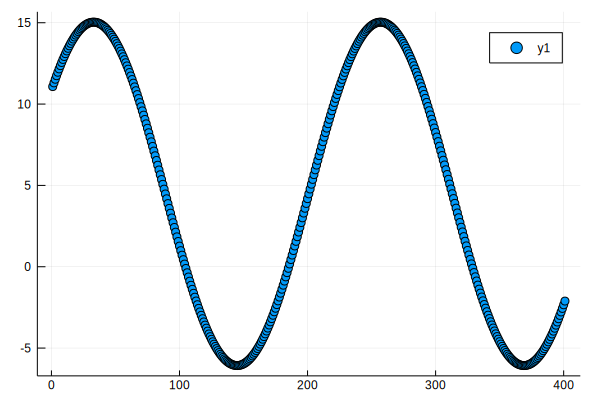

In [4]:
scatter(generate_basic_paf_datum()[1])

### MLDatasets Feature: `splitobs`
For breaking up into test, dev and training sets etc.

In [5]:
const basic_paf_full = [generate_basic_paf_datum() for _ in 1:20_000];
const basic_paf_train, basic_paf_dev, basic_paf_test = splitobs(basic_paf_full, at=(0.7, 0.1));
length.([basic_paf_train, basic_paf_dev, basic_paf_test])

3-element Array{Int64,1}:
 14000
  2000
  4000

In [6]:
train_data = basic_paf_train
dev_data = basic_paf_dev
test_data = basic_paf_test

train_x = mapreduce(first, hcat, train_data)' |> collect
train_y = mapreduce(collect∘last, hcat, train_data)' |> collect;

dev_x = mapreduce(first, hcat, dev_data)' |> collect
dev_y = mapreduce(collect∘last, hcat, dev_data)' |> collect;

test_x = mapreduce(first, hcat, test_data)' |> collect
test_y = mapreduce(collect∘last, hcat, test_data)' |> collect;

# Model  Definition

In [7]:
function make_tf_basic_paf(in_size = length(basic_paf_train[1][1]))
    sess = Session(Graph())
    @tf begin
        x = placeholder(Float32, shape=[missing, in_size])

        W1 = get_variable((in_size, 128), Float32)
        b1 = get_variable(128, Float32)
        z1 = nn.relu(x*W1 + b1)


        W2 = get_variable((128, 128), Float32)
        b2 = get_variable(128, Float32)
        z2 = nn.relu(z1*W2 + b1)

        W3 = get_variable((128, 3), Float32)
        b3 = get_variable(2, Float32)

        y = placeholder(Float32, shape=[missing, 3])
        yp = identity([z2*W3[:, 1:2] + b3 tanh.(z2*W3[:, 3:3])])


        net_loss = reduce_mean((y .- yp).^2)
        opt = train.minimize(train.AdamOptimizer(), net_loss)
    end
    run(sess, global_variables_initializer())
    
    return (sess=sess, opt=opt)
end

make_tf_basic_paf (generic function with 2 methods)

In [8]:
function make_flux_basic_paf(in_size = length(basic_paf_train[1][1]))
    W = param(0.01randn(3, 512))
    b = param(0.01randn(2))

    return Chain(
        Dense(in_size, 512, relu), 
        Dense(512, 512, relu), 
        z->[W[1:2,:]z + b; tanh.(W[3:3,:]z)]
    )
end

make_flux_basic_paf (generic function with 2 methods)

## Model Use 

In [9]:
@time let 
    sess, _ = make_tf_basic_paf()
    t1, o1 = basic_paf_train |> first
    
    run(sess, sess.graph["yp"], Dict(sess.graph["x"]=>t1'))'
end

2019-02-09 21:26:10.422125: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


 51.385087 seconds (74.97 M allocations: 4.141 GiB, 4.25% gc time)


3×1 LinearAlgebra.Adjoint{Float32,Array{Float32,2}}:
 -0.021338496 
  0.006912849 
 -0.0045985603

In [10]:
@time let 
    model = make_flux_basic_paf()
    t1, o1 = basic_paf_train |> first
    model(t1)
end

  1.478387 seconds (4.66 M allocations: 250.171 MiB, 10.18% gc time)


Tracked 3-element Array{Float64,1}:
  0.28025224225868656
 -1.1815278136833651 
 -0.2456282065961022 

## Model Training

In [11]:
function train_tf(model, train_data, dev_data, test_data)
    sess, opt = model
    
    # TensorFlow wants dense matrixes
    train_x = mapreduce(first, hcat, train_data)'
    train_y = mapreduce(collect∘last, hcat, train_data)';
    
    dev_x = mapreduce(first, hcat, dev_data)'
    dev_y = mapreduce(collect∘last, hcat, dev_data)';

    test_x = mapreduce(first, hcat, test_data)'
    test_y = mapreduce(collect∘last, hcat, test_data)';

    ######
    

    loss_dev = run(sess, sess.graph["net_loss"], Dict(sess.graph["x"]=>dev_x, sess.graph["y"]=>dev_y))
    @show loss_dev
    
    prev_loss_dev = loss_dev
    for epoch in 1:10
        for (batch_x, batch_y) in eachbatch((train_x, train_y), 1000, ObsDim.First())
            run(sess, opt, Dict(sess.graph["x"]=>train_x, sess.graph["y"]=>train_y))
        end
    
        loss_dev = run(sess, sess.graph["net_loss"], Dict(sess.graph["x"]=>dev_x, sess.graph["y"]=>dev_y))
        @show loss_dev
        if loss_dev > prev_loss_dev
            break # early stopping
        end
        prev_loss_dev = loss_dev
    end
    
    test_loss = run(sess, sess.graph["net_loss"], Dict(sess.graph["x"]=>test_x, sess.graph["y"]=>test_y))
    @show test_loss
    return model
end

train_tf (generic function with 1 method)

In [12]:
function train_flux(model, train_data, dev_data, test_data)
    function loss_(x, y)
        ŷ = model(x)
        mean((ŷ .- y).^2)
    end

    opt = ADAM()
    
        
    loss_dev = mean(dev_data) do (x,y)
        loss_(x, y)
    end
    @show loss_dev
    
    prev_loss_dev = loss_dev
    for epoch in 1:10
        for batch in eachbatch(train_data, 1000)
            Flux.train!(loss_, params(model), batch, opt)
        end
    
        loss_dev = mean(dev_data) do (x,y)
            loss_(x, y)
        end
        @show loss_dev
        if loss_dev > prev_loss_dev
            break # early stopping
        end
        prev_loss_dev = loss_dev
    end
    
    test_loss = mean(test_data) do (x,y)
        loss_(x, y)
    end
    @show test_loss
    return model
end

train_flux (generic function with 1 method)

## Training time

In [13]:
GC.gc() 
@time train_tf(make_tf_basic_paf(), basic_paf_train, basic_paf_dev, basic_paf_test);

loss_dev = 24.461637f0
loss_dev = 16.443012f0
loss_dev = 16.613049f0
test_loss = 16.715977f0
 28.643636 seconds (5.86 M allocations: 29.210 GiB, 23.00% gc time)


In [14]:
GC.gc()
@time train_flux(make_flux_basic_paf(), basic_paf_train, basic_paf_dev, basic_paf_test);

loss_dev = 24.457753277870804 (tracked)
loss_dev = 16.588201373312664 (tracked)
loss_dev = 16.52637229264744 (tracked)
loss_dev = 16.525175041604548 (tracked)
loss_dev = 16.528505091743913 (tracked)
test_loss = 16.656737762304758 (tracked)
456.133317 seconds (72.86 M allocations: 300.824 GiB, 11.52% gc time)


# Under Noise

In [15]:
function generate_noisy_paf_datum()
    p = 5randn()
    a = 7randn()
    f = randn()
    
    x= -2:0.01:2
    np = [0.1*randn() for _ in x]
    na = [0.1*randn() for _ in x]
    nf = [0.005*randn() for _ in x]

    
    input =  @. a*sin(2π*(f+nf)*x + np) + p + na
    output = @SVector[p, a, f]
    return (input, output)
end

generate_noisy_paf_datum (generic function with 1 method)

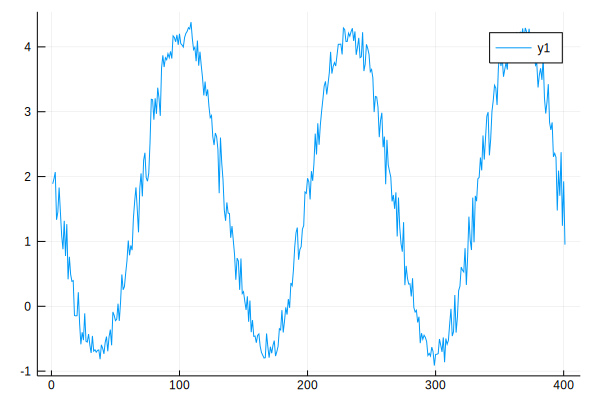

In [16]:
x, y = generate_noisy_paf_datum()
plot(x)

In [17]:
const noisy_paf_full = [generate_noisy_paf_datum() for _ in 1:20_000];
const noisy_paf_train, noisy_paf_dev, noisy_paf_test = splitobs(noisy_paf_full, at=(0.7, 0.1));
length.([noisy_paf_train, noisy_paf_dev, noisy_paf_test])

3-element Array{Int64,1}:
 14000
  2000
  4000

In [18]:
GC.gc()
@time train_flux(make_flux_basic_paf(), noisy_paf_train, noisy_paf_dev, noisy_paf_test);

loss_dev = 25.326788236356116 (tracked)
loss_dev = 16.828085530513214 (tracked)
loss_dev = 16.978102103365117 (tracked)
test_loss = 17.02137639973157 (tracked)
215.808362 seconds (25.97 M allocations: 149.970 GiB, 11.77% gc time)


In [19]:
GC.gc() 
@time train_tf(make_tf_basic_paf(), noisy_paf_train, noisy_paf_dev, noisy_paf_test);

loss_dev = 25.030828f0
loss_dev = 17.186892f0
loss_dev = 16.789434f0
loss_dev = 16.684027f0
loss_dev = 16.659916f0
loss_dev = 16.604519f0
loss_dev = 16.606968f0
test_loss = 16.784616f0
 32.194263 seconds (3.22 M allocations: 31.479 GiB, 21.35% gc time)


# NonStationary
This is impossible for this basic architechture that is ingornat of time to do well on

In [26]:
function generate_ns_paf_datum(t)
    p = 5randn()
    a = 7randn()
    f = randn()
    
    x= -2:0.01:2
    np = sin(0.1t)
    na = (t-0.5)^2
    nf = 0.01t
     
    input =  @. a*sin(2π*(f+nf)*x) + p + na
    output = @SVector[p, a, f]
    return (input, output)
end

generate_ns_paf_datum (generic function with 1 method)

In [27]:
const ns_paf_full = [generate_ns_paf_datum(ii/200_000) for ii in 1:2_000];
const ns_paf_train, ns_paf_dev, ns_paf_test = splitobs(ns_paf_full, at=(0.7, 0.1));
length.([ns_paf_train, ns_paf_dev, ns_paf_test])

3-element Array{Int64,1}:
 1400
  200
  400

In [30]:
GC.gc()
@time train_flux(make_flux_basic_paf(), ns_paf_train, ns_paf_dev, ns_paf_test);

loss_dev = 25.411727958437105 (tracked)
loss_dev = 17.525473332139907 (tracked)
loss_dev = 16.1253730808223 (tracked)
loss_dev = 16.220864442993662 (tracked)
test_loss = 18.528116339973284 (tracked)
 23.285102 seconds (2.80 M allocations: 16.079 GiB, 12.17% gc time)


In [29]:
GC.gc() 
@time train_tf(make_tf_basic_paf(), ns_paf_train, ns_paf_dev, ns_paf_test);

loss_dev = 25.216208f0
loss_dev = 24.922535f0
loss_dev = 24.411327f0
loss_dev = 23.609915f0
loss_dev = 22.463982f0
loss_dev = 20.980827f0
loss_dev = 19.215944f0
loss_dev = 17.460209f0
loss_dev = 16.215866f0
loss_dev = 16.139832f0
loss_dev = 16.85988f0
test_loss = 18.124052f0
  3.552880 seconds (3.07 M allocations: 2.025 GiB, 14.18% gc time)
